# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ast


from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm

from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

#from tensorflow.keras.applications.resnet50 import preprocess_input


from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, as_completed

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input


# Access Dataset
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem. 




In [3]:
df_data = pd.read_csv('dataset\\full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# Data Distribution
- Below is shown the distribution of images available for each different ocular condition. The different diseases are encoded into individual coloums as N (Normal), D (Diabetes), G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia), O (Other diseases/abnormalities). They have binary indicators 0 or 1 to specify the absence or presence of a condition. This is also know as one-hot encoding. Thus, the dataset structure indicates multiple labels per image, allowing for multi-label classifcation.

- Conditions G, C, A, H and M are minority classes since they have low image samples, causing class imbalance. 

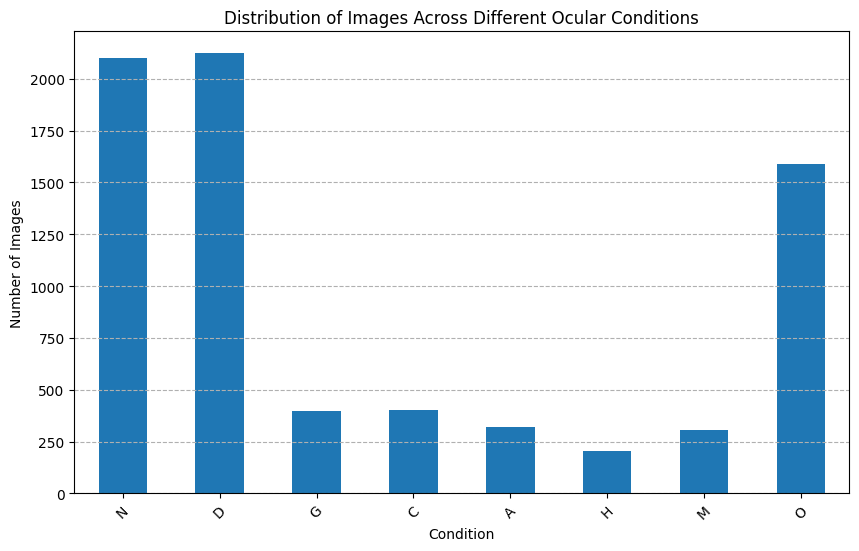

In [3]:
# Sum up the occurrences of each condition
class_counts = df_data[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].sum()

# Plotting
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Images Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()

# Dealing with class imbalance - Data Augmentation 
- Data augmentation involves artificially increasing the size of your dataset by generating new data by resusing exisitng data, useful for underrepresented classes. Examples include rotations, flipping, noise, colour variations. 
- Will increase each minority class size to 2000 images by using the class counts and classes with less than 2000 images will be augmeneted to increase their size to 2000.
- The following minority classes should have their class sizes balanced -  G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia).

Filtering the Minority Classes

In [31]:
max_count = max(class_counts)
augmentations_needed = {class_label: max_count - count for class_label, count in class_counts.items()}
augmentations_needed

{'N': 22,
 'D': 0,
 'G': 1726,
 'C': 1721,
 'A': 1804,
 'H': 1920,
 'M': 1817,
 'O': 535}

In [30]:
def create_augmented_data_generator(X, y, augmentations_needed):
    # Create an instance of the ImageDataGenerator
    if augmentations_needed:
        datagen = ImageDataGenerator(
            rotation_range=augmentations_needed['rotation_range'],
            shear_range=augmentations_needed['shear_range'],
            zoom_range=augmentations_needed['zoom_range'],
            horizontal_flip=augmentations_needed['horizontal_flip'],
            vertical_flip=augmentations_needed['vertical_flip'],
            fill_mode=augmentations_needed['fill_mode'],
            preprocessing_function=preprocess_input
        )
    else:
        datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    # Create a generator for the data
    generator = datagen.flow(X, y, batch_size=32)
    
    return generator

def create_data_generator(X, y):
    # Create an instance of the ImageDataGenerator
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    # Create a generator for the data
    generator = datagen.flow(X, y, batch_size=32)
    
    return generator

In [34]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
augmentations_needed = {
    'rotation_range': 5,
    'shear_range': 0.2,
    'zoom_range': 0.5,
    'horizontal_flip': True,
    'vertical_flip': True,
    'fill_mode': 'constant'
}

def load_and_preprocess_images(filenames, base_path='dataset/ODIR-5K/Training Images', target_size=(256, 256)):
    images = []
    for filename in filenames:
        # Prepend the base path to the filename to get the full path
        full_path = os.path.join(base_path, filename)
        # Load the image
        img = load_img(full_path, target_size=target_size)
        # Convert the image to a numpy array
        img_array = img_to_array(img)
        # Normalize the image array and append it to the images list
        images.append(img_array / 255.0)
    return np.array(images)

    # Function to load and process images
    def load_images(batch_file_paths):
        return np.array([load_and_preprocess_image(fp) for fp in batch_file_paths])

    # Generator function
    def generator():
        num_samples = len(file_paths)
        while True:  # Loop indefinitely
            for offset in range(0, num_samples, batch_size):
                # Get the data for this batch
                batch_file_paths = file_paths[offset:offset+batch_size]
                batch_labels = labels[offset:offset+batch_size]

                # Load and process the images
                batch_images = load_images(batch_file_paths)

                # One-hot encode the labels if not already one-hot
                batch_labels = to_categorical(batch_labels, num_classes=8)

                yield batch_images, batch_labels

    return generator()


X = load_and_preprocess_images(df_data['filename'].values)
y_list = np.array(df_data['target'].apply(ast.literal_eval).tolist())
y = np.array([np.argmax(yi) for yi in y_list])



# Define the K-fold Cross Validator
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):
    
#
  
    # You would need to implement a function or a procedure here that takes
    # the train and test indices and prepares the data generators accordingly
    # Create your data generators
    train_generator = create_augmented_data_generator(X[train], y[train], augmentations_needed)
    validation_generator = create_data_generator(X[test], y[test])
    

    
    # Define the model architecture/function (or you could also compile your model here)
    def get_model():
        # Recreate the ResNet50 model as you have done previously
        model = ResNet50(include_top=False, input_shape=(512,512, 3), pooling='avg',classes=8, weights='imagenet')
        # Freeze the layers
        for layer in model.layers:
            layer.trainable = False
        # Add your own layers to the pre-trained model
        # un-freeze the BatchNorm layers
        for layer in model.layers:
            if "BatchNormalization" in layer.__class__.__name__:
                layer.trainable = True
        # Add your own layers to the pre-trained model
        model = Sequential()
        model.add(ResNet50(include_top=False, input_shape=(256, 256, 3), pooling='avg',classes=8, weights='imagenet'))
        model.add(Flatten())
        model.add(Dense(1024, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(8, activation='softmax'))
        
        # Compile the model
        model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
        
           
        return model





MemoryError: Unable to allocate 4.68 GiB for an array with shape (6392, 256, 256, 3) and data type float32

In [35]:
augmentations_needed = {
    'rotation_range': 5,
    'shear_range': 0.2,
    'zoom_range': 0.5,
    'horizontal_flip': True,
    'vertical_flip': True,
    'fill_mode': 'constant'
}

# Modify this function to only handle one image at a time
def load_and_preprocess_image(filename, base_path='dataset/preprocessed_images', target_size=(512, 512)):
    # Prepend the base path to the filename to get the full path
    full_path = os.path.join(base_path, filename)
    # Load the image
    img = load_img(full_path, target_size=target_size)
    # Convert the image to a numpy array and normalize it
    img_array = img_to_array(img) / 255.0
    return img_array

# Update your data generator to process images on the fly
def create_data_generator(file_paths, labels, augmentations_needed, batch_size=32):
    # Create an instance of the ImageDataGenerator with the specified augmentations
    datagen = ImageDataGenerator(**augmentations_needed)
    
    # Generator function
    def generator():
        num_samples = len(file_paths)
        while True:  # Loop indefinitely
            for offset in range(0, num_samples, batch_size):
                # Get the data for this batch
                batch_file_paths = file_paths[offset:offset + batch_size]
                batch_labels = labels[offset:offset + batch_size]
                
                # Load and process the images
                batch_images = np.array([load_and_preprocess_image(fp) for fp in batch_file_paths])
                
                # One-hot encode the labels if not already one-hot
                batch_labels = to_categorical(batch_labels, num_classes=8)

                yield batch_images, batch_labels

    return generator

# Now convert the labels from one-hot encoded to integer encoded for StratifiedKFold
y_integers = np.array([np.argmax(yi) for yi in y_list])

# Define the K-fold Cross Validator
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)

# Initialize the model architecture outside the loop
def get_model():
    # Create the base model from the pre-trained model ResNet50
    base_model = ResNet50(include_top=False, input_shape=(256, 256, 3), pooling='avg', weights='imagenet')
    # Freeze the layers of the base model
    for layer in base_model.layers:
        if "BatchNormalization" in layer.__class__.__name__:
            layer.trainable = True
        else:
            layer.trainable = False
            
    # Create the new model on top of the base model
    model = Sequential([
        base_model,
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(8, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y_integers):
    model = get_model()  # Get the model
    
    # Get the file paths for train and test
    X_train_files = df_data['filename'].values[train]
    X_test_files = df_data['filename'].values[test]
    # Get the labels for train and test
    y_train = y_integers[train]
    y_test = y_integers[test]
    
    # Create your data generators
    train_generator = create_data_generator(X_train_files, y_train, augmentations_needed)
    validation_generator = create_data_generator(X_test_files, y_test, augmentations_needed)
    
    # Fit data to model
    history = model.fit(
        train_generator(),  # Call the generator function to get the generator
        validation_data=validation_generator(),
        epochs=50,
        steps_per_epoch=len(X_train_files) // 32,
        validation_steps=len(X_test_files) // 32,
        verbose=1
    )
    
    # Increase fold number
    fold_no += 1

Epoch 1/50


In [ ]:
x, y = train_generator.next()
print(x.shape, y.shape)

(32, 256, 256, 3) (32,)


In [ ]:
x,y = validation_generator.next()
print(x.shape, y.shape)

(32, 256, 256, 3) (32,)


In [20]:
    # Create a new model for the current fold
    model = get_model()
    
    # Setup callbacks
    checkpoint = ModelCheckpoint(filepath='best_model.h5', verbose=1, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    callbacks = [early_stopping, checkpoint, reduce_lr]
    
    # Fit data to model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=50,
        callbacks=callbacks,
        verbose=1
    )
    
    # Generate generalization metrics and add them to some list to later calculate mean and std
    scores = model.evaluate(validation_generator, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==

Epoch 1/50


ValueError: in user code:

    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\losses.py", line 1787, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\backend.py", line 5119, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 8) are incompatible


In [4]:
# Split the DataFrame into training and test sets
df_train, df_test = train_test_split(df_data, test_size=0.2, random_state=42)

labels
['N']    2304
['D']    1275
['O']     572
['C']     235
['G']     223
['A']     220
['M']     184
['H']     100
Name: count, dtype: int64


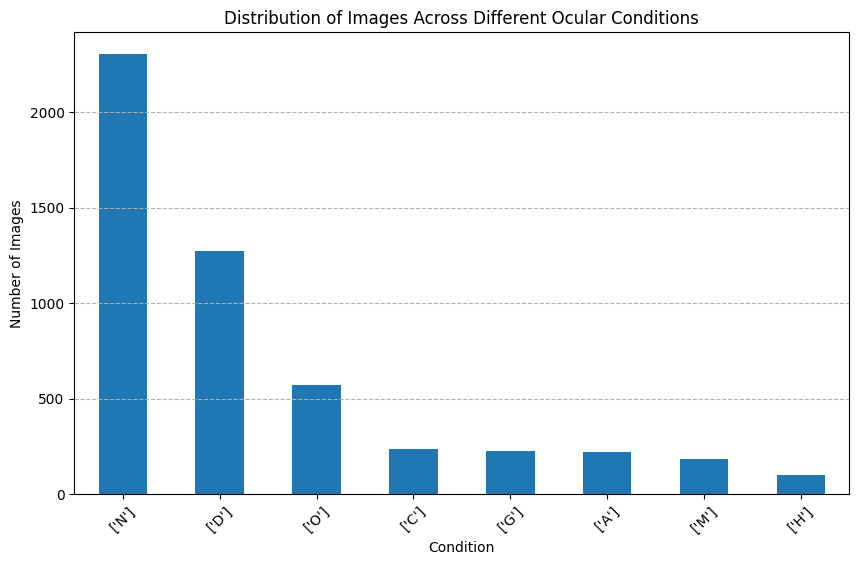

In [7]:
class_counts = df_train['labels'].value_counts()
print(class_counts)

# Plotting
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Images Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()

In [9]:
max_count = max(class_counts)
augmentations_needed = {class_label: max_count - count for class_label, count in class_counts.items()}
augmentations_needed

{"['N']": 0,
 "['D']": 1029,
 "['O']": 1732,
 "['C']": 2069,
 "['G']": 2081,
 "['A']": 2084,
 "['M']": 2120,
 "['H']": 2204}

In [ ]:

# Initialize the ImageDataGenerator with suitable augmentations for fundus images
augmentation = ImageDataGenerator(
    rotation_range=5,         # Slightly reduce the rotation range
    zoom_range=0.05,          # Reduce the zoom range
    brightness_range=(0.95, 1.05), # Narrow the brightness range
    fill_mode='constant',     # Change fill mode to 'constant'
    cval=0,                   # Set constant value to 0 (black) which might be more appropriate for fundus images
    # Consider adding a shear range if it makes sense for your data
)

save_directory = 'dataset/augmented_images/'
os.makedirs(save_directory, exist_ok=True)

# The augmentations_needed dictionary now uses numerical indices as keys
augmentations_needed = { 0:0, 1:1, 2:10, 3:9, 4:10, 5:23, 6:12, 7:4 }

def augment_and_save_image(row, save_directory, augmentation, augmentations_needed):
    img_path = os.path.join('dataset/ODIR-5K/Training Images', row['filename'])
    img = load_img(img_path)
    img = img.resize((256, 256))  # Resize image if necessary
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    augmented_rows = []

    # Determine the number of augmentations needed based on the target
    # Determine the number of augmentations needed based on the target
    targets = eval(row['target']) if isinstance(row['target'], str) else row['target']
    max_augmentations_needed = max([augmentations_needed[i] for i, label in enumerate(targets) if label == 1])

    for i in range(max_augmentations_needed):
        for batch in augmentation.flow(x, batch_size=1, save_prefix='aug_', save_format='jpeg'):
            # Create a unique filename using class index and augmentation index
            unique_filename = f'aug_{i}_{row["filename"]}'
            # Generate the full path for saving
            augmented_image_path = os.path.join(save_directory, unique_filename)
            # Save the image to the full path
            save_img(augmented_image_path, batch[0])

            # Replicate the row and update the filename
            augmented_row = row.copy()
            augmented_row['filename'] = unique_filename
            augmented_rows.append(augmented_row)

            break  # Only save one image per augmentation to avoid infinite loop

    return augmented_rows  # Return the augmented rows with updated filenames

# Usage with ThreadPoolExecutor
augmented_data = []

with ThreadPoolExecutor(max_workers=4) as executor:
    tasks = []
    for _, row in df_train.iterrows():
        tasks.append(executor.submit(augment_and_save_image, row, save_directory, augmentation, augmentations_needed))

    for future in tqdm(as_completed(tasks), total=len(tasks), desc="Augmenting Images"):
        try:
            augmented_rows = future.result()
            augmented_data.extend(augmented_rows)  # Extend the list with augmented rows
        except Exception as e:
            print(f"Error processing image: {e}")

# Create a DataFrame from the augmented data
df_augmented = pd.DataFrame(augmented_data)

# Concatenate the original DataFrame with the new augmented DataFrame
df_combined = pd.concat([df_train, df_augmented], ignore_index=True)


In [6]:
df_augmented.head()

# save to csv

df_augmented.to_csv('dataset\\df_augmented.csv', index=False)

In [7]:
df_combined.head()

# save to csv

df_combined.to_csv('dataset\\full_df_augmented.csv', index=False)

Class N: 2304
Class D: 2550
Class G: 2453
Class C: 2350
Class A: 2420
Class H: 2400
Class M: 2392
Class O: 2860


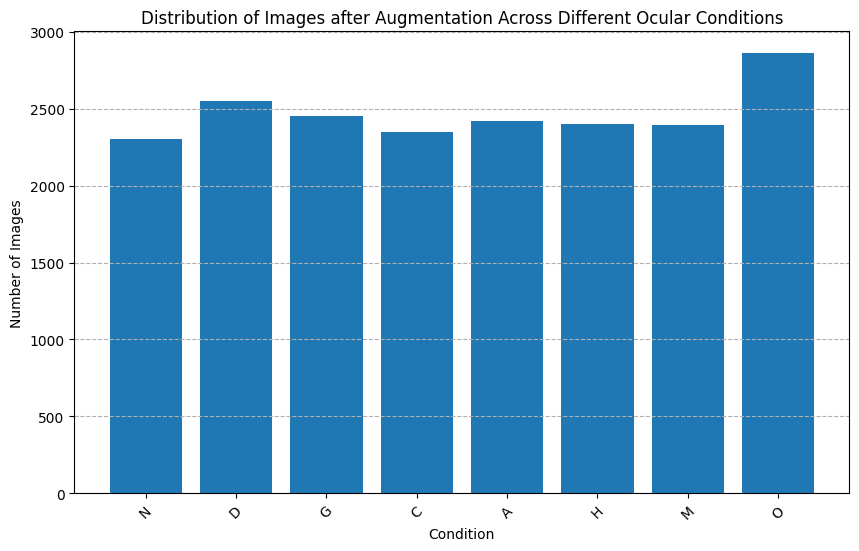

In [30]:


# Convert string representation of list to actual list using ast.literal_eval
df_combined['target'] = df_combined['target'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Ensure all lists are of equal length (this step assumes all lists should be length 8)
# If some 'target' entries are not lists or are lists of different lengths, this will give an error
assert all(len(t) == 8 for t in df_combined['target']), "Not all target lists are of length 8."

# Sum up all the target lists
class_distribution = np.sum(df_combined['target'].tolist(), axis=0)

# Assuming class_labels are in the correct order
class_labels = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Map the distribution counts to the class labels
class_distribution_dict = dict(zip(class_labels, class_distribution))

# Print the class distribution
for label, count in class_distribution_dict.items():
    print(f"Class {label}: {count}")
    
# Plotting
plt.figure(figsize=(10, 6))
class_distribution_dict = dict(zip(class_labels, class_distribution))
plt.bar(class_distribution_dict.keys(), class_distribution_dict.values())
plt.title('Distribution of Images after Augmentation Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')



In [5]:
df_combined = pd.read_csv('dataset\\full_df_augmented.csv')
df_combined.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,3159,62,Male,3159_left.jpg,3159_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3159_right.jpg
1,3315,57,Male,3315_left.jpg,3315_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3315_left.jpg
2,2152,58,Female,2152_left.jpg,2152_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",2152_left.jpg
3,542,64,Male,542_left.jpg,542_right.jpg,diabetic retinopathy,maculopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",542_left.jpg
4,540,82,Male,540_left.jpg,540_right.jpg,normal fundus,dry age-related macular degeneration，diabetic ...,0,1,0,0,1,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['A'],"[0, 0, 0, 0, 1, 0, 0, 0]",540_right.jpg


In [6]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [31]:
datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=preprocess_input
    
)

train_generator = datagen.flow_from_dataframe(
    dataframe= df_combined,  # Use the training part of the split
    directory='dataset/augmented_train_img/', 
    x_col='filename',
    y_col='labels',
    subset='training',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df_combined,  # Use the training part of the split
    directory='dataset/augmented_train_img/',
    x_col='filename',
    y_col='labels',
    subset='validation',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 15784 validated image filenames belonging to 8 classes.
Found 3945 validated image filenames belonging to 8 classes.


In [32]:
# For the test set, you can create a separate ImageDataGenerator instance without a validation split

test_generator = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory='dataset/ODIR-5K/Training Images',
    x_col='filename',
    y_col='labels',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical', 
    shuffle=False
)

Found 1279 validated image filenames belonging to 8 classes.


In [33]:
x,y = test_generator.next()
x.shape

(32, 224, 224, 3)

# Loading and Visualising the Training Data 

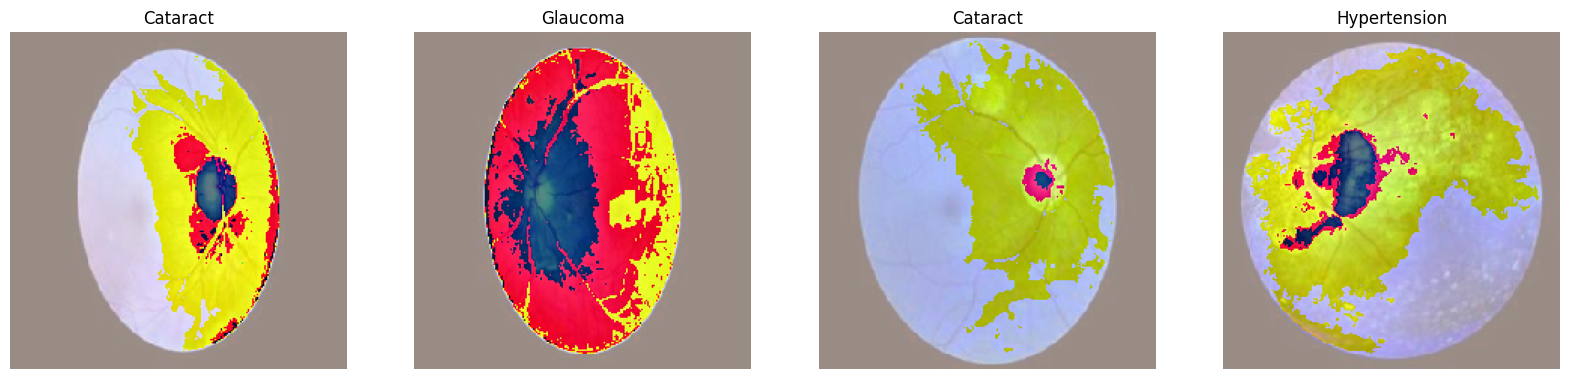

In [34]:
# Get the next batch of images from the training generator
images, labels = next(train_generator)
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Plot the images and labels using the show_batch function
def show_batch(images, labels, ncols=4):
    figure, axs = plt.subplots(1, ncols, figsize=(20, 20))
    for i in range(ncols):
        axs[i].imshow(images[i].astype('uint8'))
        axs[i].set_title(class_labels[np.argmax(labels[i])])
        axs[i].axis('off')
        
show_batch(images, labels, ncols=4)

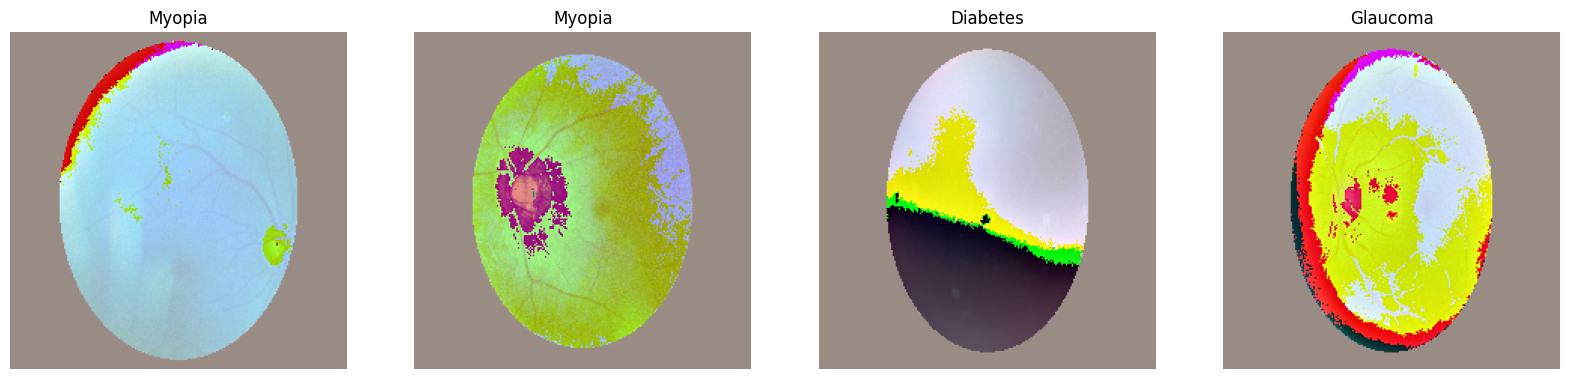

In [35]:
images, labels = next(validation_generator)
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Plot the images and labels using the show_batch function
def show_batch(images, labels, ncols=4):
    figure, axs = plt.subplots(1, ncols, figsize=(20, 20))
    for i in range(ncols):
        axs[i].imshow(images[i].astype('uint8'))
        axs[i].set_title(class_labels[np.argmax(labels[i])])
        axs[i].axis('off')
        
show_batch(images, labels, ncols=4)

# Training the model

- A BatchNormalization layer and a Dropout layer are added immediately after flattening the output of the pretrained ResNet50 base. A Dense layer with both L1 and L2 regularization follows the Dropout layer. The regularization helps prevent overfitting by adding a penalty for larger weights, and Dropout randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Batch Normalization normalizes the inputs heading into the next layer, which ensures that the network always creates activations with the same distribution that we desire.

# Early Stopping 
- This is implemented to prevent overfitting if the validation loss begins to rise consisenly as training goes on. 

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [37]:
validation_steps=validation_generator.samples // 32
print(validation_steps)

123


In [38]:
steps_per_epoch=train_generator.samples // 32
print(steps_per_epoch)

493


In [39]:
import tensorflow as tf
# Set the random seed for reproducibility
tf.random.set_seed(42)

# Clear any previous models from memory
tf.keras.backend.clear_session()

# Recreate the model
resnet_50_model = Sequential()
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224,224, 3),
    pooling='avg',
    classes=8,
    weights='imagenet'
)
for layer in pretrained_model.layers:
    layer.trainable = False
resnet_50_model.add(pretrained_model)
resnet_50_model.add(Flatten())
resnet_50_model.add(Dense(512, activation='relu'))
resnet_50_model.add(Dropout(0.5))
resnet_50_model.add(Dense(8, activation='softmax'))

# Fine-tuning
# Unfreeze some of the last layers of the base model
for layer in pretrained_model.layers[-15:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

# Compile the model
resnet_50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [40]:
resnet_50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24,640,904
Trainable params: 6,563,336
Non-trainable params: 18,077,568
_________________________________________________________________


In [41]:
# Setup callbacks
checkpoint = ModelCheckpoint(filepath='best_model.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

callbacks = [early_stopping, checkpoint, reduce_lr]

# Fit the model with callbacks
history = resnet_50_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)


Epoch 1/50
493/493 [==============================] - ETA: 0s - loss: 0.9135 - accuracy: 0.6612
Epoch 1: val_loss improved from inf to 1.06236, saving model to best_model.h5
493/493 [==============================] - 137s 274ms/step - loss: 0.9135 - accuracy: 0.6612 - val_loss: 1.0624 - val_accuracy: 0.5567 - lr: 1.0000e-04
Epoch 2/50
493/493 [==============================] - ETA: 0s - loss: 0.3917 - accuracy: 0.8507
Epoch 2: val_loss improved from 1.06236 to 1.04249, saving model to best_model.h5
493/493 [==============================] - 128s 259ms/step - loss: 0.3917 - accuracy: 0.8507 - val_loss: 1.0425 - val_accuracy: 0.5828 - lr: 1.0000e-04
Epoch 3/50
493/493 [==============================] - ETA: 0s - loss: 0.2245 - accuracy: 0.9086
Epoch 3: val_loss improved from 1.04249 to 0.97366, saving model to best_model.h5
493/493 [==============================] - 124s 251ms/step - loss: 0.2245 - accuracy: 0.9086 - val_loss: 0.9737 - val_accuracy: 0.5709 - lr: 1.0000e-04
Epoch 4/50
493

# Evaluating Model 

Model Accuracy Graph Analysis

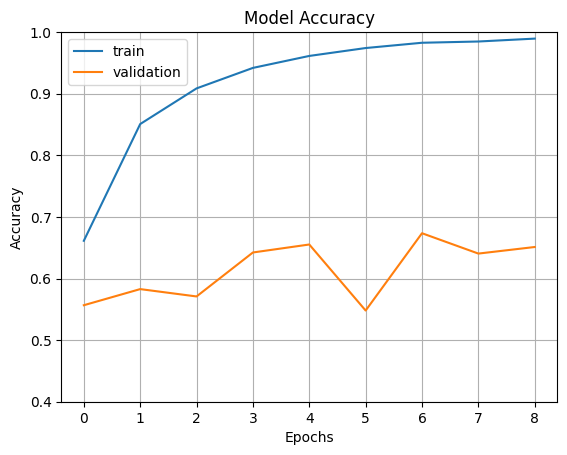

In [42]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Model Loss Graph Analysis 

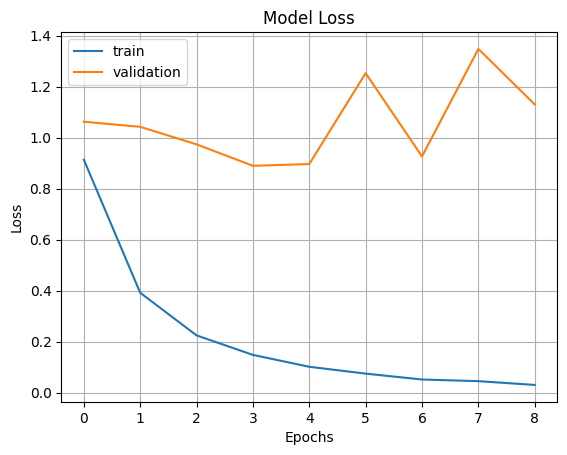

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions

In [19]:
# Assuming these were stored from the original generator before wrapping
test_samples = test_generator.samples
test_batch_size = test_generator.batch_size

# Calculate the correct number of steps to cover all the samples
steps = np.ceil(test_samples / test_batch_size)

# Evaluate the model on the test dataset
resnet_50_model.evaluate(test_generator, steps=steps)

# Re-generate predictions with the corrected steps
predictions = resnet_50_model.predict(test_generator, steps=steps)

# Get the predicted classes again
predicted_classes = np.argmax(predictions, axis=1)


40/40 [==============================] - 17s 413ms/step


# Predictions Result Evaluation

In [20]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

Classification Report 

In [22]:

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Get the true classes from the DataFrame
true_classes = test_generator.classes

# Now, the number of predicted classes should match the number of true classes
# Generate the classification report again
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print(report)


                precision    recall  f1-score   support

        Normal       0.50      0.26      0.34        46
      Diabetes       0.76      0.72      0.74        58
      Glaucoma       0.51      0.37      0.43       333
      Cataract       0.42      0.28      0.34        61
           AMD       0.36      0.14      0.21        28
  Hypertension       0.84      0.88      0.86        48
        Myopia       0.57      0.75      0.65       569
Other diseases       0.26      0.20      0.22       136

      accuracy                           0.54      1279
     macro avg       0.53      0.45      0.47      1279
  weighted avg       0.53      0.54      0.52      1279



Balanced Accuracy Score 

In [23]:
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

Balanced Accuracy: 0.4501


Area Under the Reciever Operating Characteristic Curve (AUC-ROC)

In [24]:
from keras.utils import to_categorical
true_classes_one_hot = to_categorical(true_classes, num_classes=8)

# Calculate ROC AUC for multi-class classification
roc_auc = roc_auc_score(true_classes_one_hot, predictions, average='macro', multi_class='ovo')

print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 0.8429


Confusion Matrix 

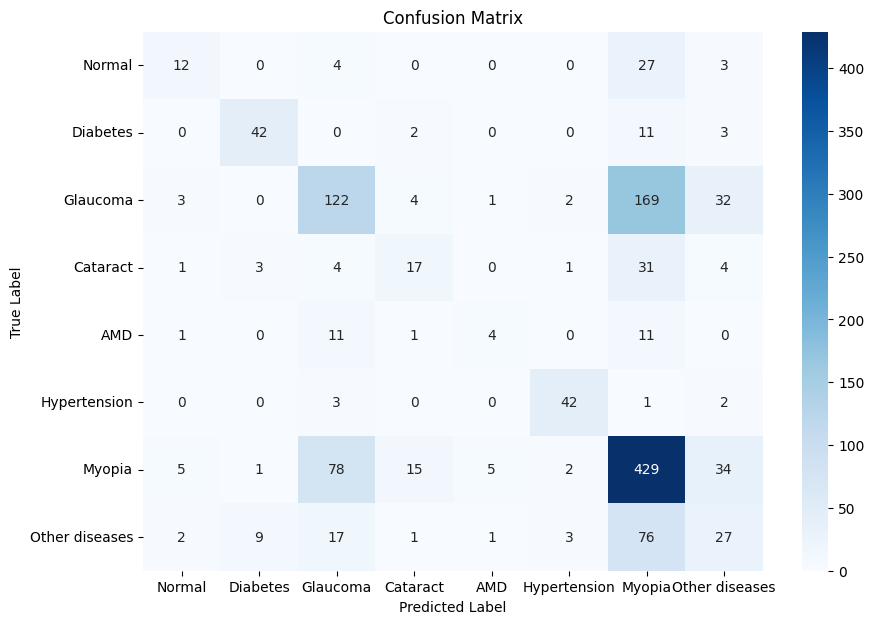

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Prediction Evaluation

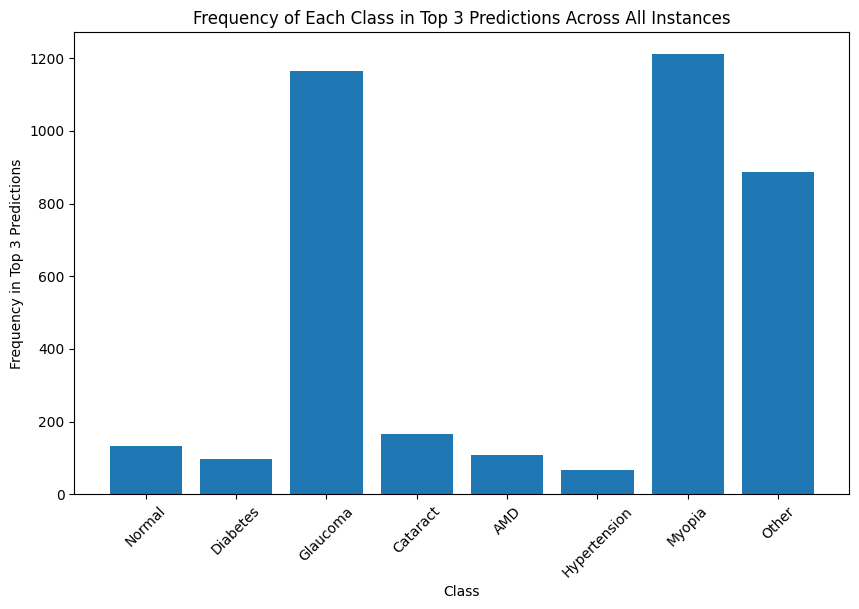

In [28]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1



# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Save the model
resnet_50_model.save('resnet_50_model_v2.h5')